# There should have been other stuff but i guess that got deleted somehow...
Conclusion was that n_g has next to none effect on the fidelity

In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [10]:
T = 30

function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

# function limit_func(param,pmin,pmax)
#     (pmax - pmin) * (1/(1 + exp(-param))) + pmin
# end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,T/2)
    Tₚ = T - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,T/2)
    Tₚ = T - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    if t < Tₐ || t > Tₐ+Tₚ
        return 0
    end
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = amp
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

Es07 = eigvals(Matrix(KinPot12 + 0.7 .* Potential3))
ψs07 = eigvecs(Matrix(KinPot12 + 0.7 .* Potential3));

function DRAGalpha(t)
    Tₐ = T/3#limit_func(p[2],0,15)
    Tₚ = T - 2*Tₐ#p[3]
    αmin = 0.7#limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

function DRAGpulse(df,t)
    if t < T/3 || t > 2*T/3
        return 0
    end
    Tₐ = T/3#limit_func(p[2],0,15)
    Tₚ = T - 2*Tₐ#p[3]
    Tᵣ = 2#limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = 0#p[5]
    f = df*real(Es07[2] - Es07[1])#p[6]
    A = 1.0/abs(ψs07[:,1]'*chargecoupling*ψs07[:,2])#p[7]
    # Φ_ext = p[8]
    # λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) #+ Edot*λ*sin(arg)
end

DRAGpulse (generic function with 1 method)

In [129]:
T/3

6.666666666666667

In [19]:
# p = [1.8096066788458205,
# 10.151415509076779,
# 10.0,
# 0.7265360232227066,
# 2.819743639160394,
# 2.0448639414672374,
# 4.08982325027897,
# 3.1258846903218442,
# 0.03571156893603993];
# p = [1.2318092112021264,
# 1.3040581104319997,
# 2.3409156521345227,
# -0.8039188206245269,
# 0.032611913255041716,
# 3.085920593099706,
# 3.44031002762207,
# 3.1258846903218442,
# -0.436638686114786]
# p = [0.2519033711380618,
# 0.8136411345628743,
# 10.0,
# -0.45707351739468677,
# 0.25008477928909373,
# 2.4464742926734213,
# 0.742789737311359,
# 3.1258846903218442,
# -0.0798193692978878
# ]
# p = [2.0,
# 10.0,
# 10.0,
# 0.7,
# 1.8410836437809366,
# 2.4788560906225645,
# 3.527526663435302,
# 3.1258846903218442,
# -0.27721491876638443]
p = [2.0,
10.0,
10.0,
0.7,
0.5418,
2.4237061150395447,
3.44314831140435,
3.1258846903218442,
0.05289]
;


In [17]:
times = LinRange(0,T,1000)

ψs = eigvecs(Matrix(KinPot12 + Potential3))

# Fidels = []
# for df in LinRange(0.92,0.94,10)
#     function H!(du, u, p, t)
#         du[:] = -im .* ((KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u)
#         # du[:] = -im .* ((KinPot12 + DRAGalpha(t) .* Potential3 + DRAGpulse(df,t) .* chargecoupling) * u)
#     end

#     forward_prob = ODEProblem(H!, ψs[:,1:2], (0.0, T))
#     sol = solve(forward_prob, save_everystep=false, reltol=1e-10, abstol=1e-10) ;
#     UT = abs2.(ψs'*sol.u[end][:,1:2])
#     push!(Fidels,0.5 .* (2 - UT[1,2] - UT[2,1]))
# end

In [34]:
LinRange(0.92,0.94,10)[argmin(Fidels)]

0.9333333333333333

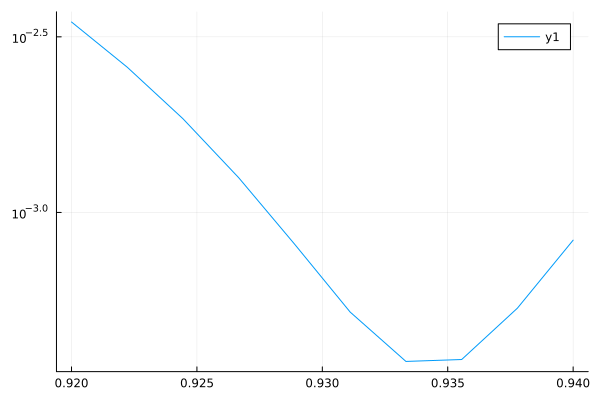

In [120]:
plot(LinRange(0.92,0.94,10),Fidels,yscale=:log10)

In [20]:
ψs = eigvecs(Matrix(KinPot12 + Potential3))

function H!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u)
    # du[:] = -im .* ((KinPot12 + DRAGalpha(t) .* Potential3 + DRAGpulse(0.9333,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(H!, ψs[:,1:2], (0.0, T), p)
sol = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10) ;

In [21]:
occs = zeros(Float64,length(sol.t),2,2)

for (i, t) in enumerate(sol.t)
    Es, ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψs'*sol.u[i])
end

In [8]:
colors = ["#0F956F" "#BA2936" "#000852"]

1×3 Matrix{String}:
 "#0F956F"  "#BA2936"  "#000852"

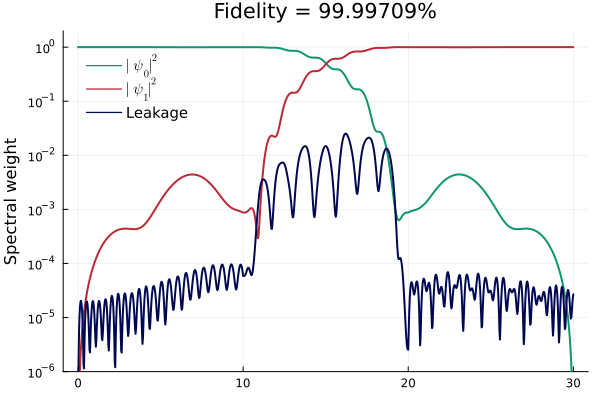

In [22]:
# using Markdown
using LaTeXStrings
Occs_plot = plot(sol.t,
     [occs[:,1,1], occs[:,2,1], abs.(1 .- (occs[:,1,1] + occs[:,2,1]))],
     yaxis=:log10,
     ylim=(1e-6,2),
     linewidth=2,
     # yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     # xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Leakage"],
     legend=:topleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10,
     color=colors,
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:8]*"%",
)

In [14]:
# savefig(plt,"HighFidelitySwapOccupation.png")

4.235359463788946e-5

In [55]:
# t_scale = round(Int,limit_func(p[2],0,15)/30 * 1000)
p[2]

1.3040581104319997

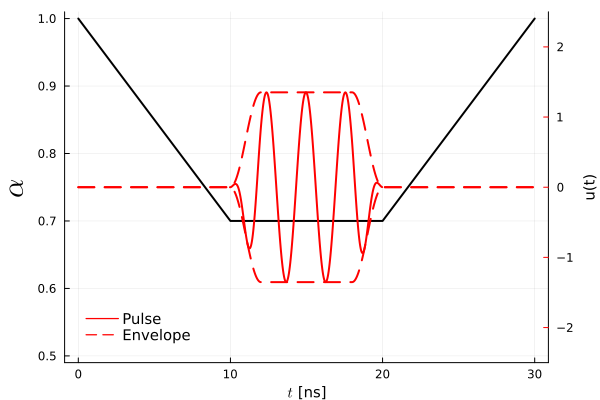

In [23]:
tmp_p = copy(p)
tmp_p[6] = 0
# tmp_p[9] = 0
tmp_p[5] = 0

tmp_p2 = copy(p)
tmp_p2[6] = 0
# tmp_p2[9] = 0
tmp_p2[5] = pi/2

pulse_plot = plot(times,
     [alpha(p,t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

plot!(twinx(),
      [times[333:666],times, times],
      [[pulse(p,t) for t in times[333:666]],
       [sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times],
       [-sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-2.5,2.5),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      ylabel="u(t)",
      legend=:bottomleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,
      axiscolor=:red,
      xlabel="\n"*L"$t$ [ns]")

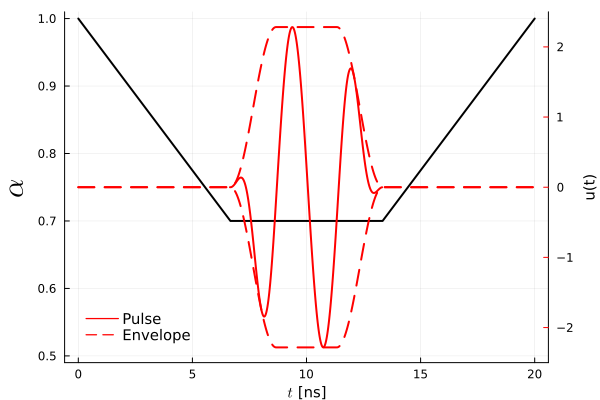

In [146]:
tmp_p = copy(p)
tmp_p[1] = 2
tmp_p[2] = T/3
tmp_p[6] = 0
tmp_p[9] = 0
tmp_p[7] = 1.0/abs(ψs07[:,1]'*chargecoupling*ψs07[:,2])/(T/3-2)
tmp_p[5] = 0

pulse_plot = plot(times,
     [DRAGalpha(t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

t_scale = round(Int,limit_func(p[2],0,15)/30 * 1000)
plot!(twinx(),
      [times[333:666],times,times],
      # [[pulse(p,t) for t in times[333:666]],[pulse(tmp_p,t) for t in times],[-pulse(tmp_p,t) for t in times]],
      [[DRAGpulse(0.9333,t) for t in times[333:666]],[pulse(tmp_p,t) for t in times],[-pulse(tmp_p,t) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-2.5,2.5),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      legend=:bottomleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,
      xlabel="\n"*L"$t$ [ns]",
      ylabel="u(t)",
      axiscolor=:red)

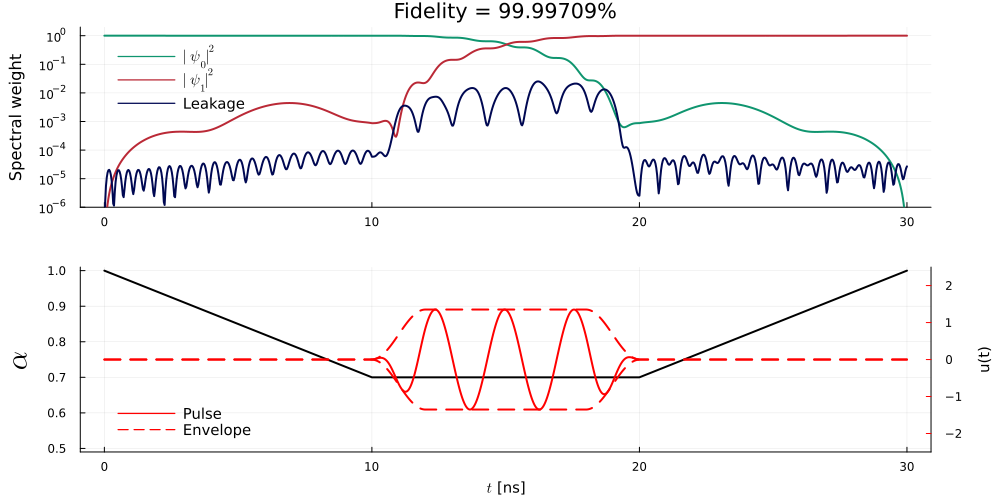

In [24]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)

In [25]:
# savefig(plt,"XGateDRAG.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\XGateDRAG.pdf"

In [42]:
1.0/abs(ψs07[:,1]'*chargecoupling*ψs07[:,2])

3.3903937841233924

In [148]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)
# savefig(plt,"BaselineSwapGatePulseT20.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\BaselineSwapGatePulseT20.pdf"

In [183]:
N = 20

function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,N+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 100/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    out/w_sum
    # envelope(t)*out/w_sum
end
function exps(p, ht,t)
    p*exp( - 10/(2*dt^2) * (t - ht)^2)
end


exps (generic function with 1 method)

In [142]:
p = rand(N) .* 2 .- 1
# p[1] = 0
# p[:] = -1 .* p
;

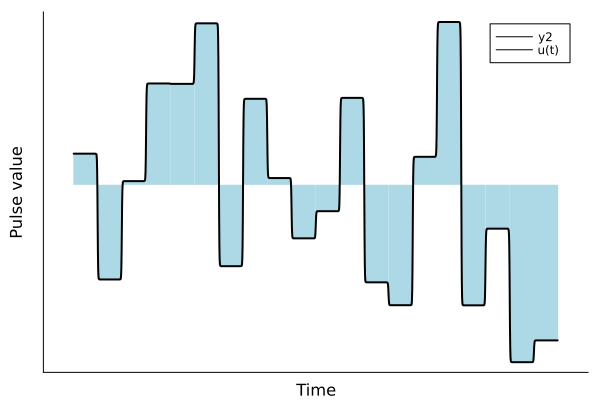

In [190]:
plt = bar(h_times,p,
    linestyle=:solid,
    linewidth=0,
    linecolor=:lightblue,
    fillcolor=:lightblue,
    bar_width=1.43,
    label=nothing,
    yticks=nothing,xticks=nothing,
    xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)

# xs = Vector(h_times)
# plot!([reshape(xs .- xs[1],1,20); reshape(xs,1,20)],[reshape(p,1,20);reshape(p,1,20)],
#       color=:black,linestyle=:solid,linewidth=2,label=nothing)
plot!(times[50:end-50],[pulse(p,t) for t in times[50:end-50]],color=:black,linewidth=2,ls=:solid,yticks=nothing,xticks=nothing,xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)

plot!([],[],label="u(t)",color=:black,linestyle=:solid,linewidth=2)
# plot!([[1 2 3] ; [2 3 4]], [[-1 0 1];[-1 0 1]])

In [191]:
savefig(plt,"PieceWiseInterpolation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\PieceWiseInterpolation.pdf"

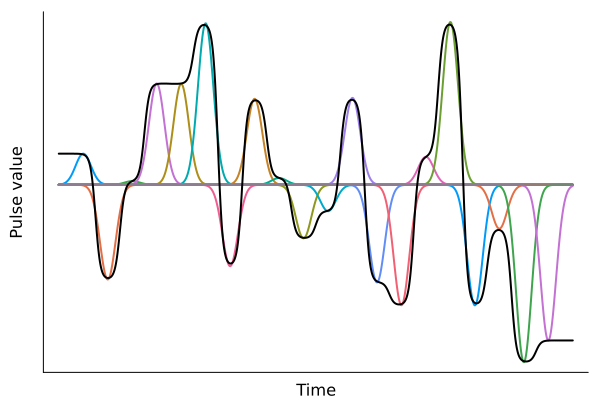

In [181]:
plt = plot(times,[[exps(p[i],h_times[i], t) for t in times] for i in 1:N],legend=nothing,linewidth=2)
plot!(times,zeros(length(times)),color=:grey,lw=2.2,alpha=0.8)
plot!(times,[pulse(p,t) for t in times],color=:black,linewidth=2,ls=:solid,yticks=nothing,xticks=nothing,xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)
plot!([],[],label="u(t)",color=:black,linestyle=:solid,linewidth=2)

In [182]:
# savefig(plt,"GaussianInterpolation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\GaussianInterpolation.pdf"

In [291]:
occs = zeros(Float64,length(sol.t),2,2)

for (i, t) in enumerate(sol.t)
    Es, ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψs'*sol.u[i])
end

2000-element Vector{Float64}:
  0.0
  0.015007503751875937
  0.030015007503751873
  0.04502251125562781
  0.06003001500750375
  0.07503751875937968
  0.09004502251125562
  0.10505252626313157
  0.1200600300150075
  0.13506753376688344
  ⋮
 29.879939969984992
 29.89494747373687
 29.909954977488745
 29.92496248124062
 29.939969984992498
 29.954977488744372
 29.969984992496247
 29.984992496248125
 30.0